In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Creating an Image-Based Home Search Engine

## The Business Challenge:
For e-commerce platforms, particularly those selling products where images factor into the purchase decision, like appliances, furniture or real estate, the limitations of traditional keyword-based search create significant friction in the customer journey. A user often has a clear visual idea of the product they want but may struggle to describe it with a precise set of keywords (e.g., "mid-century modern home with a big front lawn"). This mismatch between visual intent and text-based search can lead to user frustration, poor search results, and ultimately, abandoned shopping carts.

The business objective is to create a more intuitive and effective product discovery experience that aligns with how users think visually. The technical challenge is to build a system that can accept an image as a search query and return a ranked list of the most visually similar products from a catalog of potentially millions of items. Solving this problem of visual search is critical for improving search relevance, increasing customer engagement, and driving higher conversion rates.



## The Data Science Approach:
For this use case, our approach is to implement a large-scale similarity search system using vector embeddings. We will treat the problem of visual similarity as one of proximity in a high-dimensional vector space, building the entire workflow on BigQuery's native multimodal capabilities. We will start by using a remote foundation model, called from a BigQuery ML SQL query, to convert each product image into a high-dimensional vector embedding. To enable fast querying over millions of vectors, we will create a VECTOR INDEX on the embeddings.

The search functionality is then exposed through the VECTOR_SEARCH function. When a user provides a query image, we will convert it into an embedding and use this function to find the products with the closest embeddings in the indexed catalog, returning a ranked list of visually similar items in real-time.


In [ ]:
#@title Util function to display images
import io
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

def printImages(results):
 image_results_list = list(results)
 amt_of_images = len(image_results_list)

 fig, axes = plt.subplots(nrows=amt_of_images, ncols=2, figsize=(20, 20))
 fig.tight_layout()
 fig.subplots_adjust(hspace=0.5)
 for i in range(amt_of_images):
   gcs_uri = image_results_list[i][0]
   text = image_results_list[i][1]
   f = tf.io.gfile.GFile(gcs_uri, 'rb')
   stream = io.BytesIO(f.read())
   img = Image.open(stream)
   axes[i, 0].axis('off')
   axes[i, 0].imshow(img)
   axes[i, 1].axis('off')
   axes[i, 1].text(0, 0, text, fontsize=10)
 plt.show()

### Instructions:

*   Replace PROJECT_ID and DATASET_ID with your own project_id and dataset_id.
*   Create a connection (image_embed_conn) in the US region and give service account access by following these steps [here](https://cloud.google.com/bigquery/docs/generate-visual-content-embedding#create_a_connection).






In [ ]:
#@title Create BQML model


%%bigquery
CREATE OR REPLACE MODEL `PROJECT_ID.DATASET_ID.home_search`
REMOTE WITH CONNECTION `PROJECT_ID.us.image_embed_conn`
OPTIONS (ENDPOINT = 'multimodalembedding@001');


Query is running:   0%|          |

""


In [ ]:
#@title Create external table
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE `PROJECT_ID.DATASET_ID.external_images_table`
WITH CONNECTION `PROJECT_ID.us.image_embed_conn`
OPTIONS(
object_metadata = 'SIMPLE',
uris = ['gs://dataproc-metastore-public-binaries/home_image_search/house_images/*'],
max_staleness = INTERVAL 1 DAY,
metadata_cache_mode = 'AUTOMATIC');


Query is running:   0%|          |

""


In [ ]:
#@title Generate embeddings for the images

%%bigquery
CREATE OR REPLACE TABLE `PROJECT_ID.DATASET_ID.home_embeddings` AS
SELECT *
FROM ML.GENERATE_EMBEDDING(
 MODEL `PROJECT_ID.DATASET_ID.home_search`,
 TABLE `PROJECT_ID.DATASET_ID.external_images_table`,
 STRUCT(TRUE AS flatten_json_output,
 512 AS output_dimensionality)
);


Query is running:   0%|          |

""


In [ ]:
%%bigquery
SELECT * FROM `PROJECT_ID.DATASET_ID.home_embeddings`;

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_embedding_result,ml_generate_embedding_status,ml_generate_embedding_start_sec,ml_generate_embedding_end_sec,uri,generation,content_type,size,md5_hash,updated,metadata,ref
0,"[0.00170754874, -0.00557596376, -0.00211487222...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_4.jpg,1754863021647372,image/jpeg,392488,47583b30fae5099d7d058dc0820b6d40,2025-08-10 21:57:01.691000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_4....
1,"[-0.0882345214, -0.00588591583, -0.00451133586...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_11.jpg,1754863024146133,image/jpeg,632509,dc8efe369ba75c6a25d904598f3d2b24,2025-08-10 21:57:04.190000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_11...
2,"[-0.0384819955, -0.0112360427, -0.00566492416,...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_77.jpg,1754863042873748,image/jpeg,645866,e713421be34b07d788d130366e868796,2025-08-10 21:57:22.919000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_77...
3,"[-0.006142681, 0.0257897396, -0.0100141568, -0...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_53.jpg,1754863036291028,image/jpeg,577108,487dd352b28e01224d2ee65eb8b0cab2,2025-08-10 21:57:16.345000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_53...
4,"[-0.056001734, 0.0483862534, -0.0376037434, -0...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_44.jpg,1754863033575136,image/jpeg,608098,17e8515d2e0eecb6c7e8a5ad0b610444,2025-08-10 21:57:13.619000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_44...
...,...,...,...,...,...,...,...,...,...,...,...,...
75,"[-0.0415544175, 0.0317841247, -0.0177392736, -...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_9.jpg,1754863023060972,image/jpeg,581190,364c99a9b601edeffb6703f3a4804a64,2025-08-10 21:57:03.106000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_9....
76,"[-0.0677347407, 0.0373012275, -0.010345336, -0...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_42.jpg,1754863032940456,image/jpeg,694726,d0e3ca9034ba0778df77c118ee0a36d9,2025-08-10 21:57:12.985000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_42...
77,"[-0.0354521945, -0.00948965, -0.0269596539, -0...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_73.jpg,1754863041807702,image/jpeg,478171,94a877a614b82163ad2da1d2c60448a9,2025-08-10 21:57:21.853000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_73...
78,"[-0.0546639226, -0.0436149202, -0.00268257572,...",,<NA>,<NA>,gs://ebook_bqml/house_images/house_80.jpg,1754863043980542,image/jpeg,611149,ef49f2ad5978cf9e2c5af598ada20bd5,2025-08-10 21:57:24.025000+00:00,[],{'uri': 'gs://ebook_bqml/house_images/house_80...


## Create Vector Indexes

Use a vector index to enable faster and more scalable semantic search. A vector index efficiently finds the nearest neighbors of a query embedding within a large collection of embeddings using the CREATE VECTOR INDEX statement.
While vector indexes are ideal for large datasets, we are not creating an index in this case because we are only generating embeddings for 80 images.

Learn more about Vector Indexes on BigQuery [here](https://cloud.google.com/bigquery/docs/vector-index#choose-vector-index-type).




In [ ]:

# %%bigquery
# CREATE OR REPLACE
#   VECTOR INDEX `house_images_index`
# ON
#   DATASET_ID.home_embeddings(ml_generate_embedding_result)
#   OPTIONS (
#     index_type = 'IVF',
#     distance_type = 'COSINE');

In [ ]:
# %%bigquery
# SELECT table_name, index_name, index_status,
#   coverage_percentage, last_refresh_time, disable_reason
# FROM DATASET_ID.INFORMATION_SCHEMA.VECTOR_INDEXES
# WHERE index_name = 'house_images_index';

In [ ]:
#@title Create external table for the test image

%%bigquery
CREATE OR REPLACE EXTERNAL TABLE `PROJECT_ID.DATASET_ID.external_images_test_table`
WITH CONNECTION `PROJECT_ID.us.image_embed_conn`
OPTIONS(
object_metadata = 'SIMPLE',
uris = ['gs://dataproc-metastore-public-binaries/home_image_search/test_image/*'],
max_staleness = INTERVAL 1 DAY,
metadata_cache_mode = 'AUTOMATIC');

Query is running:   0%|          |

""


In [ ]:
%%bigquery
SELECT * FROM `PROJECT_ID.DATASET_ID.external_images_test_table`;

Query is running:   0%|          |

Downloading:   0%|          |

,uri,generation,content_type,size,md5_hash,updated,metadata,ref
0,gs://ebook_bqml/test_image/house_test_1.jpg,1754884521052885,image/jpeg,579525,dfac452f22a3b4965bdebada174965b7,2025-08-11 03:55:21.098000+00:00,[],{'uri': 'gs://ebook_bqml/test_image/house_test...


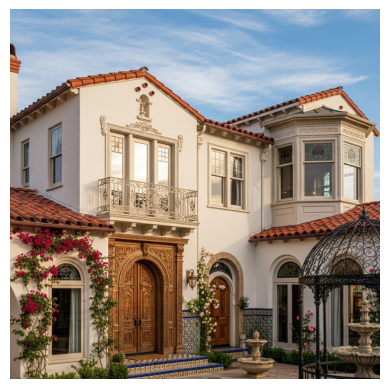

In [ ]:
    #@title Viewing the test image

    from google.cloud import storage
    from io import BytesIO
    from PIL import Image

    # Initialize a client
    storage_client = storage.Client()

    # Specify your bucket and image file name
    bucket_name = "ebook_bqml"
    blob_name = "test_image/house_test_1.jpg" # or .png, .gif, etc.

    # Get the bucket and blob
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # Download the image data into a BytesIO object
    image_bytes = blob.download_as_bytes()
    image_stream = BytesIO(image_bytes)

    # Open the image using PIL (Pillow)
    img = Image.open(image_stream)

    # Now 'img' is a PIL Image object, and you can perform operations on it
    # For example, to display it (requires matplotlib):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
#@title Generate embeddings for the test image

%%bigquery
CREATE OR REPLACE TABLE `PROJECT_ID.DATASET_ID.test_embeddings` AS
SELECT *
FROM ML.GENERATE_EMBEDDING(
 MODEL `PROJECT_ID.DATASET_ID.home_search`,
 TABLE `PROJECT_ID.DATASET_ID.external_images_test_table`,
 STRUCT(TRUE AS flatten_json_output,
 512 AS output_dimensionality)
);


Query is running:   0%|          |

""


In [ ]:
#@title Vector search

%%bigquery
CREATE OR REPLACE TABLE `PROJECT_ID.DATASET_ID.vector_search_results` AS
SELECT base.uri AS gcs_uri, distance
FROM
VECTOR_SEARCH(
 TABLE  `PROJECT_ID.DATASET_ID.home_embeddings`,
 'ml_generate_embedding_result',
 (
 SELECT * FROM `PROJECT_ID.DATASET_ID.test_embeddings`
 ),
 top_k => 10,
 distance_type => 'COSINE',
 options => '{"use_brute_force":true}'
);


Query is running:   0%|          |

""


In [ ]:

%%bigquery
SELECT * FROM `PROJECT_ID.DATASET_ID.vector_search_results`;

Query is running:   0%|          |

Downloading:   0%|          |

,gcs_uri,distance
0,gs://ebook_bqml/house_images/house_71.jpg,0.116143
1,gs://ebook_bqml/house_images/house_21.jpg,0.180058
2,gs://ebook_bqml/house_images/house_58.jpg,0.222667
3,gs://ebook_bqml/house_images/house_15.jpg,0.094637
4,gs://ebook_bqml/house_images/house_70.jpg,0.143729
5,gs://ebook_bqml/house_images/house_67.jpg,0.207217
6,gs://ebook_bqml/house_images/house_65.jpg,0.175631
7,gs://ebook_bqml/house_images/house_69.jpg,0.232384
8,gs://ebook_bqml/house_images/house_20.jpg,0.126523
9,gs://ebook_bqml/house_images/house_19.jpg,0.102197


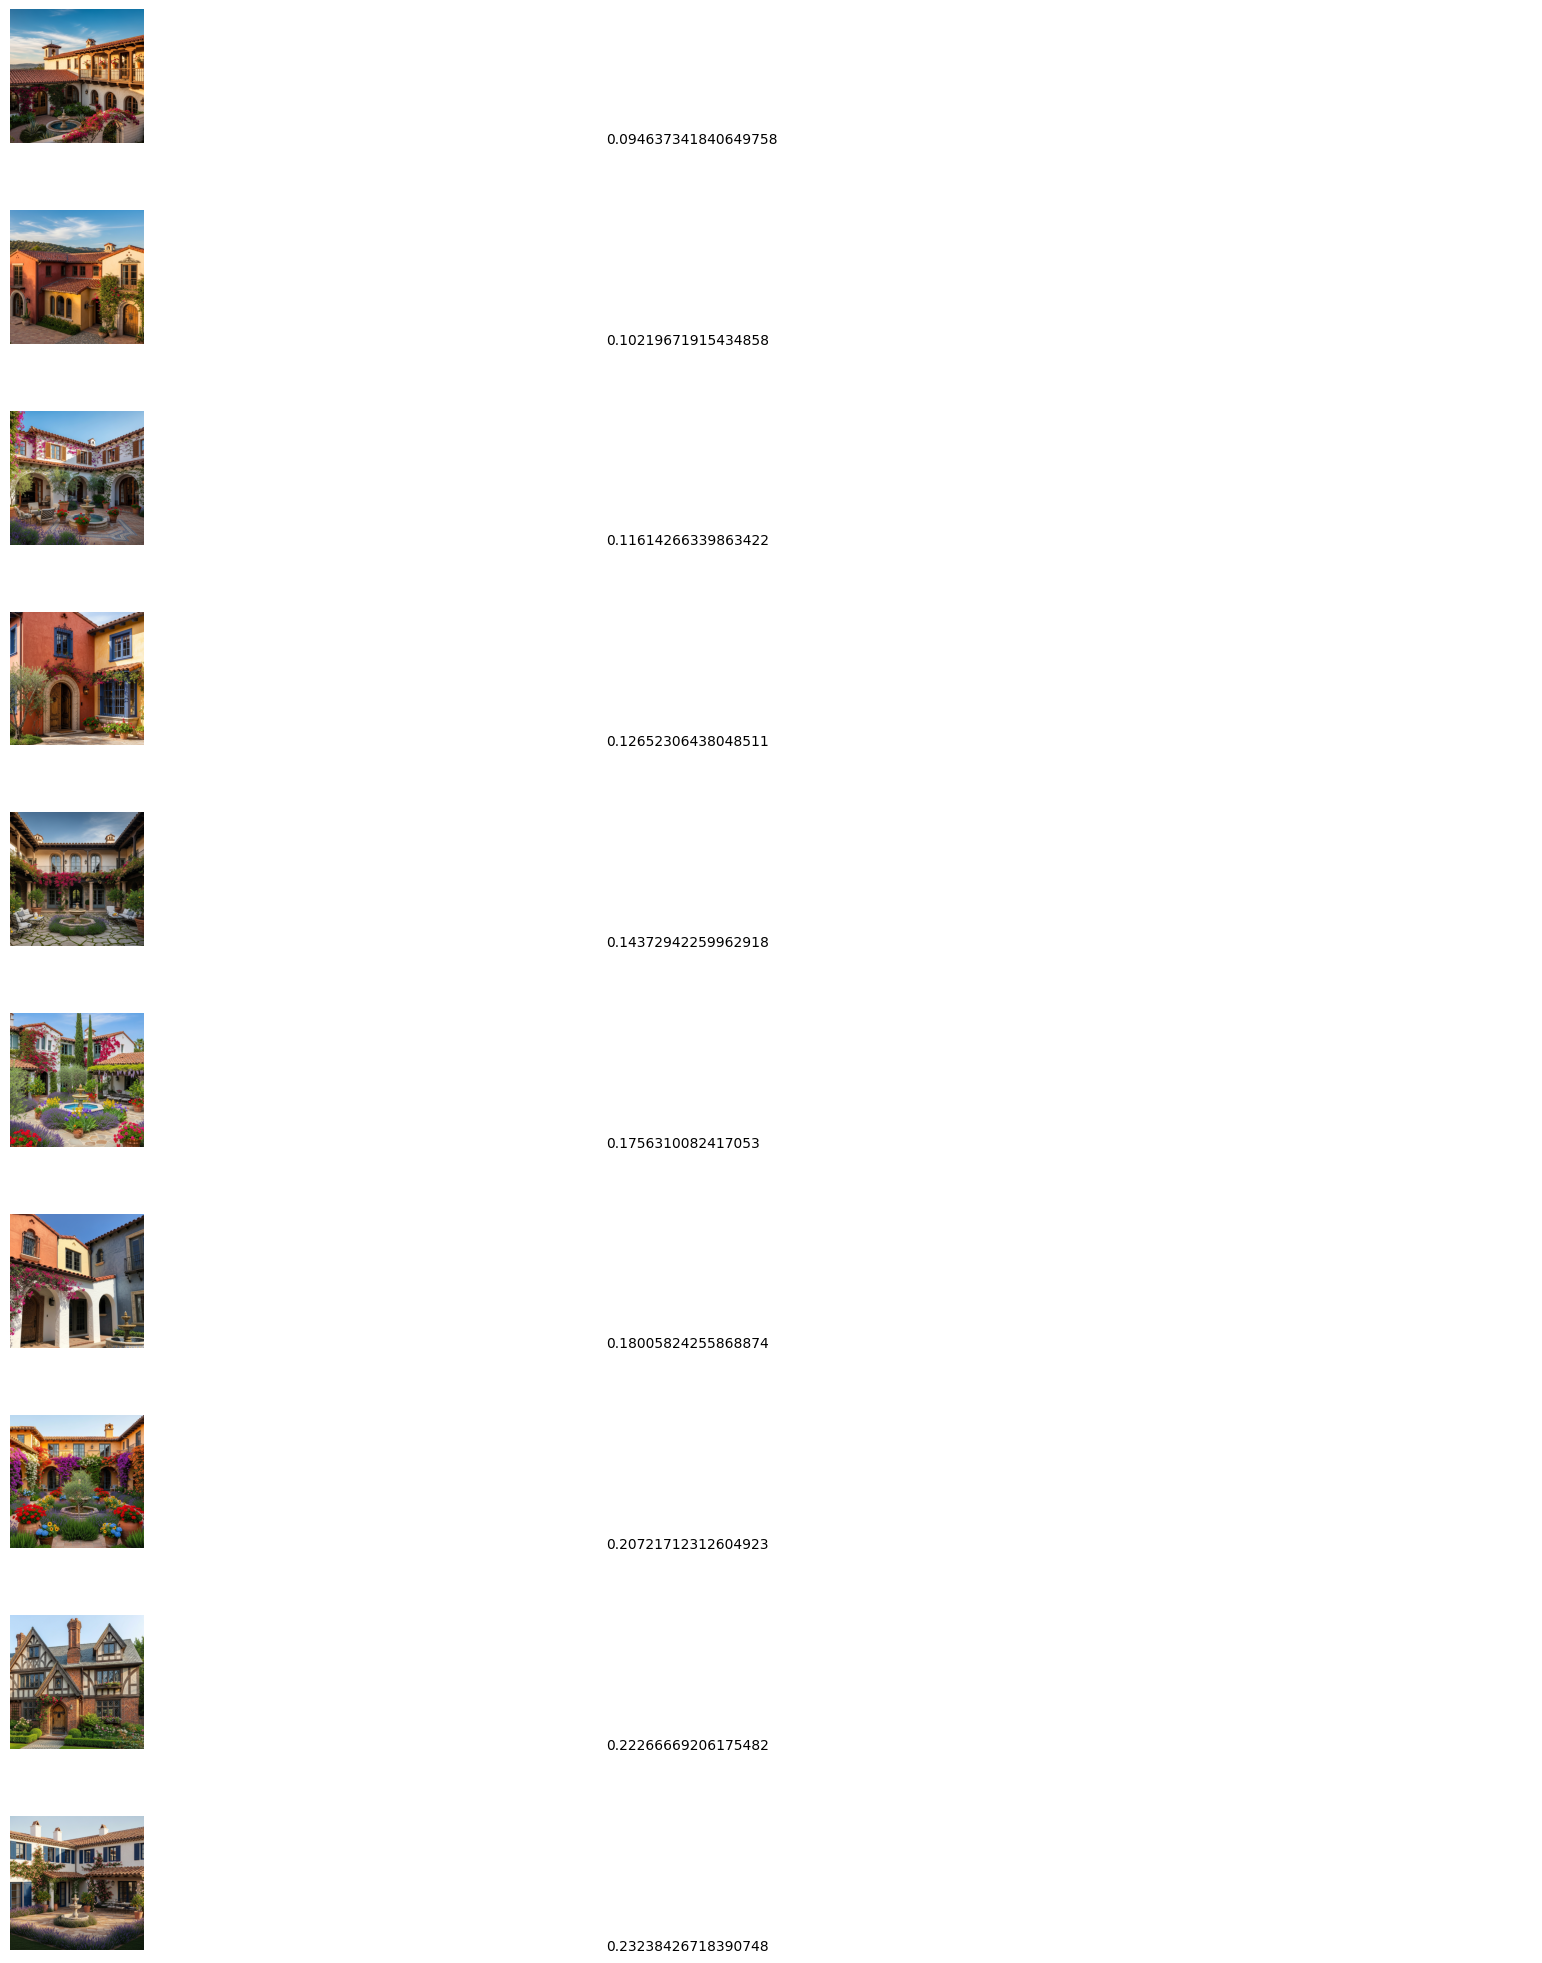

In [ ]:
#@title Viewing the search result

from google.cloud import bigquery
client = bigquery.Client()

query = """
  SELECT gcs_uri, CAST(distance AS STRING) FROM  `PROJECT_ID.DATASET_ID.vector_search_results`
  ORDER BY distance;
"""

printImages(client.query(query))

# Conclusion
Learn more about image embeddings in BigQuery [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-embedding) and Vector Search on BigQuery [here](https://cloud.google.com/bigquery/docs/vector-search-intro).





